In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import random as rn
import tensorflow.keras.backend as K
import utils

In [2]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

In [3]:
fb15k_237 = np.load('./data/fb15k_237.npz', allow_pickle=True)

In [4]:
fb_train = fb15k_237['train']
fb_valid = fb15k_237['valid']
fb_test = fb15k_237['test']

In [59]:
entities = set(np.concatenate((fb_train[:,0], 
                               fb_train[:,2],
                               fb_valid[:,0], 
                               fb_valid[:,2],
                               fb_test[:,0], 
                               fb_test[:,2]), axis=0))

all_relations = set(np.concatenate((fb_train[:,1], fb_valid[:,1], fb_test[:,1]), axis=0))

num_entities = len(entities)
num_relations = len(all_relations)

ent2idx = dict(zip(entities, range(num_entities)))
rel2idx = dict(zip(all_relations, range(num_relations)))

idx2ent = {idx:ent for ent,idx in ent2idx.items()}
idx2rel = {idx:rel for rel,idx in rel2idx.items()}

In [6]:
train2idx = []

for head, rel, tail in fb_train:
    
    head_idx = items2idx[head]
    tail_idx = items2idx[tail]
    rel_idx = items2idx[rel]

    train2idx.append([head_idx, rel_idx, tail_idx])
    
train2idx = np.array(train2idx)

In [7]:
EMBEDDING_SIZE = 50
BATCH_SIZE = 256
NUM_EPOCHS = 300
MARGIN = 2
SQRT_SIZE = 6 / np.sqrt(EMBEDDING_SIZE)

In [8]:
train_data = tf.data.Dataset.from_tensor_slices((train2idx[:,0], train2idx[:,1], train2idx[:,2]))
train_data = train_data.shuffle(buffer_size=50000).batch(BATCH_SIZE)

#exp_decay = tf.keras.optimizers.schedules.ExponentialDecay(.01, 1000, .05)
optimizer = tf.keras.optimizers.SGD(learning_rate=.001)

In [62]:
def get_entity_model():
    
    entity_input = tf.keras.layers.Input(shape=(1,), name='entity_input')
    
    entity_embedding = tf.keras.layers.Embedding(
        input_dim=num_entities,
        output_dim=EMBEDDING_SIZE,
        name='entity_embeddings',
        embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-SQRT_SIZE, maxval=SQRT_SIZE, seed=123)
        )(entity_input)
    
    #conv_1 = tf.keras.layers.Conv1D(filters=64,kernel_size=2, strides=1,padding='same', name='conv_1')(entity_embedding)
    
    #flatten = tf.keras.layers.Flatten()(conv_1)
    
    #dense = tf.keras.layers.Dense(64)(flatten)
    
    model = tf.keras.Model(inputs=entity_input, outputs=entity_embedding)
    
    return model
    
def get_relation_model():
    
    relation_input = tf.keras.layers.Input(shape=(1,), name='relation_input')

    relation_embedding = tf.keras.layers.Embedding(
        input_dim=num_relations,
        output_dim=EMBEDDING_SIZE,
        name='relation_embeddings',
        embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-SQRT_SIZE, maxval=SQRT_SIZE, seed=123)
    )(relation_input)
    
    #conv_1 = tf.keras.layers.Conv1D(filters=64,kernel_size=2, 
    #                                strides=1,padding='same', name='conv_1')(relation_embedding)
    
    #flatten = tf.keras.layers.Flatten()(conv_1)
    
    #dense = tf.keras.layers.Dense(64)(flatten)
    
    model = tf.keras.Model(inputs=relation_input, outputs=relation_embedding)
    
    return model

# def get_embedding_model():
    
#     embedding_input = tf.keras.layers.Input(shape=(1,), name='embedding_input')
    
#     embeddings = tf.keras.layers.Embedding(
#         input_dim=num_items,
#         output_dim=EMBEDDING_SIZE,
#         name='embeddings',
#         embeddings_initializer=tf.keras.initializers.RandomUniform(
#             minval=-SQRT_SIZE, maxval=SQRT_SIZE, seed=123)
#         )(embedding_input)
    
#     model = tf.keras.Model(inputs=embedding_input, outputs=embeddings)
    
#     return model

In [10]:
def dissimilarity(tensors):
    
    head, rel, tail = tensors
    
    return K.sum(K.square(head + rel - tail), axis=1, keepdims=True)

def margin(tensors):
    
    pos, neg = tensors
    
    return K.relu(pos-neg+K.constant(1))

In [68]:
def get_siamese_model():
    
    input_shape = (1,)
    
    pos_head_input = tf.keras.layers.Input(shape=input_shape, name='pos_head_input')
    neg_head_input = tf.keras.layers.Input(shape=input_shape, name='neg_head_input')
    pos_tail_input = tf.keras.layers.Input(shape=input_shape, name='pos_tail_input')
    neg_tail_input = tf.keras.layers.Input(shape=input_shape, name='neg_tail_input')
    relation_input = tf.keras.layers.Input(shape=input_shape, name='relation_input')
    
    entity_model = get_entity_model()
    relation_model = get_relation_model()
    
    pos_h_e = entity_model(pos_head_input)
    neg_h_e = entity_model(neg_head_input)
    pos_t_e = entity_model(pos_tail_input)
    neg_t_e = entity_model(neg_tail_input)
    rel_e   = relation_model(relation_input)
    
    dist = tf.keras.layers.Lambda(dissimilarity, name='dist')
    
    pos = dist([pos_h_e, rel_e, pos_t_e])
    neg = dist([neg_h_e, rel_e, neg_t_e])
    
    #margin_layer = tf.keras.layers.Lambda(margin, name='margin')
    
    #margin_vector = margin_layer([pos, neg])
    
    #preds = tf.keras.layers.Dense(1, activation='sigmoid')(margin_vector)
    
    #preds_out = tf.keras.layers.Flatten()(preds)
    
    model = tf.keras.Model(
        inputs=[pos_head_input, neg_head_input, pos_tail_input, neg_tail_input, relation_input],
        outputs=[pos, neg]
        )
    
    return model, entity_model, relation_model

In [70]:
#get labels 1 between positive triples and 0 between negative triples
siamese, entity, relation = get_siamese_model()
#siamese, entity_model = get_siamese_model()

In [13]:
siamese.output

[<tf.Tensor 'dist/Identity:0' shape=(None, 1, 50) dtype=float32>,
 <tf.Tensor 'dist_1/Identity:0' shape=(None, 1, 50) dtype=float32>]

In [15]:
losses = []
MARGIN = 2

for epoch in range(NUM_EPOCHS):
    
    for head, rel, tail in train_data:
                
        neg_head, neg_tail = utils.get_negative_triples(head, rel, tail, num_entities=num_items)
        
        with tf.GradientTape() as tape:
            
            pos, neg = siamese([head, neg_head, tail, neg_tail, rel])

            loss = tf.reduce_sum(tf.maximum(pos - neg + MARGIN, 0))
            
        grads = tape.gradient(loss,siamese.trainable_variables)
        optimizer.apply_gradients(zip(grads,siamese.trainable_variables))
    
    if not epoch % 10:
        
        print('Current loss' , loss.numpy(),'at epoch', epoch)
    
    losses.append(loss.numpy()) 

Current loss 533.8703 at epoch 0
Current loss 271.8325 at epoch 10
Current loss 186.42505 at epoch 20
Current loss 117.923935 at epoch 30
Current loss 76.492485 at epoch 40
Current loss 65.192566 at epoch 50
Current loss 66.24823 at epoch 60
Current loss 46.605885 at epoch 70
Current loss 55.72084 at epoch 80
Current loss 48.882652 at epoch 90
Current loss 29.911465 at epoch 100
Current loss 41.373055 at epoch 110
Current loss 31.131182 at epoch 120
Current loss 25.954416 at epoch 130
Current loss 13.639667 at epoch 140
Current loss 22.993206 at epoch 150
Current loss 40.844906 at epoch 160
Current loss 39.623764 at epoch 170
Current loss 25.29538 at epoch 180
Current loss 38.302948 at epoch 190
Current loss 27.010086 at epoch 200
Current loss 18.631916 at epoch 210
Current loss 14.958561 at epoch 220
Current loss 12.954778 at epoch 230
Current loss 13.031353 at epoch 240
Current loss 23.49531 at epoch 250
Current loss 16.262026 at epoch 260
Current loss 14.862534 at epoch 270
Current 

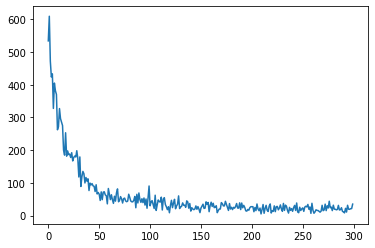

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses)

In [65]:
# paris, france = embedding(tf.convert_to_tensor([11695,12608]))

paris_str = '/m/05qtj'
france_str = '/m/0f8l9c'

capital = rel2idx['/location/country/capital']
paris_idx = ent2idx[paris_str]
france_idx = ent2idx[france_str]

paris, france = embedding_model(tf.convert_to_tensor([paris_idx, france_idx]))

In [57]:
scores = []

for i in range(len(rel2idx)):
    
    temp_rel = relation(i)
    
    score = -np.linalg.norm((paris+temp_rel - france),ord=2)
    
    scores.append(score)
    
idx2rel[np.argmax(scores)]

In [58]:
# for i in np.argsort(scores)[-10:]:
    
#     print(idx2items[i])

In [ ]:
# head_input = siamese.get_layer('pos_head_input')(head)
# tail_input = siamese.get_layer('pos_tail_input')(tail)
# rel_input = siamese.get_layer('relation_input')(rel)

# h = embedding(head_input)
# t = embedding(tail_input)
# r = relation(rel_input)

# neg_head_i = siamese.get_layer('neg_head_input')(neg_head)
# neg_tail_i = siamese.get_layer('neg_tail_input')(neg_tail)

# n_h = embedding(neg_head_i)
# n_t = embedding(neg_tail_i)